## Imports

In [107]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import tempfile

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset, random_split

In [108]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Hyper-param. for pretrain

In [109]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 256
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10
DATA_DIR = './data'

# Optimizer parameters
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# Pretraining parameters
EPOCHS = 100

# Augmentation parameters
IMAGE_SIZE = 48
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75

# Encoder and Decoder parameters
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = 2
ENC_TRANSFORMER_UNITS = [ENC_PROJECTION_DIM * 2, ENC_PROJECTION_DIM]
DEC_TRANSFORMER_UNITS = [DEC_PROJECTION_DIM * 2, DEC_PROJECTION_DIM]

### Prepare CIFAR-10

In [110]:
def get_train_transforms():
    return transforms.Compose([
        transforms.ToTensor(),  # Convert the image back to a tensor
        transforms.Resize((INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20)),  # Resize to INPUT_SHAPE + 20
        transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),  # Random crop to IMAGE_SIZE
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    ])

def get_test_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize to IMAGE_SIZE
    ])


In [111]:
def prepare_data_cifar(data_dir=DATA_DIR, batch_size=BATCH_SIZE):
    train_transform = get_train_transforms()
    test_transform = get_test_transforms()

    full_train_set = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    test_set = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_transform)

    train_size = len(full_train_set) - 10000
    train_set, val_set = random_split(full_train_set, [train_size, 10000])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [112]:
train_loader, val_loader, test_loader = prepare_data_cifar()

# Outputs to check the loader properties
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

Files already downloaded and verified
Files already downloaded and verified
Number of training batches: 157
Number of validation batches: 40
Number of testing batches: 40


## Patching and reconstruction

In [113]:
class Patches(nn.Module):
    def __init__(self, patch_size=PATCH_SIZE):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def forward(self, images):
        batch_size, channels, height, width = images.size()
        patches = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 3, 4, 5, 1).contiguous().view(batch_size, -1, self.patch_size*self.patch_size*channels)
        return patches

    def reconstruct_from_patch(self, patches):
        num_patches = patches.shape[0]
        n = int(np.sqrt(num_patches))
        patches = patches.view(num_patches, self.patch_size, self.patch_size, 3)#.permute(0, 2, 3, 1)  # (num_patches, patch_size, patch_size, 3)
        rows = torch.split(patches, n, dim=0)
        rows = [torch.cat(list(row), dim=1) for row in rows]
        reconstructed = torch.cat(rows, dim=0)
        return reconstructed

    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        img = images[idx].cpu()
        img = transforms.ToPILImage()(img)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Original Image")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = patch.view(self.patch_size, self.patch_size, 3).cpu()
            patch_img = transforms.ToPILImage()(patch_img.permute(2, 0, 1))  # Permute to (C, H, W)
            plt.imshow(patch_img)
            plt.axis("off")
        plt.show()

        return idx

Image shape: torch.Size([256, 3, 48, 48])
Patches shape: torch.Size([256, 64, 108])
Index selected: 102.


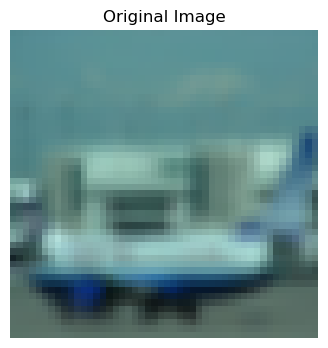

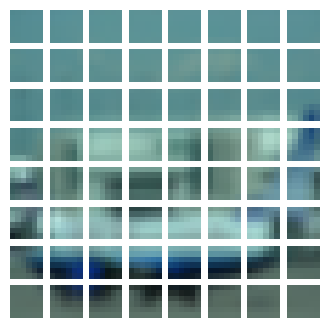

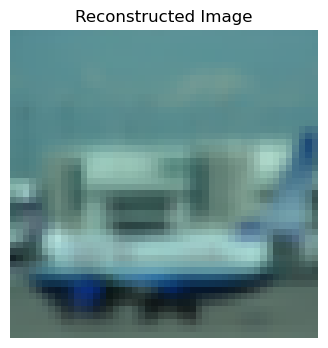

In [114]:
for images, labels in train_loader:
    break

print(f"Image shape: {images.shape}")

patch_layer = Patches(patch_size=PATCH_SIZE)

patches = patch_layer(images)

print(f"Patches shape: {patches.shape}")

random_index = patch_layer.show_patched_image(images=images, patches=patches)

reconstructed_image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.figure(figsize=(4, 4))
plt.imshow(reconstructed_image) # Convert (C, H, W) to (H, W, C) for displaying
plt.axis("off")
plt.title("Reconstructed Image")
plt.show()

## Patch encoding with masking


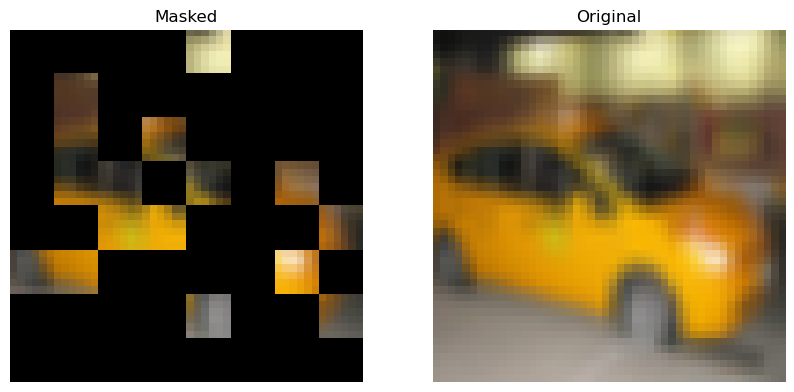

In [115]:
class PatchEncoder(nn.Module):
    def __init__(self, patch_size=PATCH_SIZE, projection_dim=ENC_PROJECTION_DIM, mask_proportion=MASK_PROPORTION, downstream=False):
        super(PatchEncoder, self).__init__()
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        self.mask_token = nn.Parameter(torch.randn(1, patch_size * patch_size * 3))

        self.projection = nn.Linear(patch_size * patch_size * 3, projection_dim)

        self.num_patches = None
        self.num_mask = None
        self.position_embedding = None

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape
        self.position_embedding = nn.Embedding(self.num_patches, self.projection_dim)
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def forward(self, patches):
        if self.num_patches is None:
            self.build(patches.shape)

        batch_size = patches.size(0)
        positions = torch.arange(self.num_patches, device=patches.device)
        pos_embeddings = self.position_embedding(positions).unsqueeze(0).repeat(batch_size, 1, 1)

        patch_embeddings = self.projection(patches) + pos_embeddings

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            unmasked_embeddings = patch_embeddings.gather(1, unmask_indices.unsqueeze(-1).expand(-1, -1, self.projection_dim))

            unmasked_positions = pos_embeddings.gather(1, unmask_indices.unsqueeze(-1).expand(-1, -1, self.projection_dim))
            masked_positions = pos_embeddings.gather(1, mask_indices.unsqueeze(-1).expand(-1, -1, self.projection_dim))

            mask_tokens = self.mask_token.repeat(batch_size, self.num_mask, 1).to(patches.device)
            masked_embeddings = self.projection(mask_tokens) + masked_positions

            return (
                unmasked_embeddings,
                masked_embeddings,
                unmasked_positions,
                mask_indices,
                unmask_indices,
            )

    def get_random_indices(self, batch_size):
        rand_indices = torch.argsort(torch.rand(batch_size, self.num_patches, device=self.position_embedding.weight.device), dim=-1)
        mask_indices = rand_indices[:, :self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask:]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, mask_indices):
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        mask_index = mask_indices[idx]

        new_patch = patch.clone()
        new_patch[mask_index] = 0  # Zero out the masked patches
        return new_patch, idx



patch_layer = Patches(patch_size=PATCH_SIZE)
data_iter = iter(train_loader)
images, _ = next(data_iter)
patches = patch_layer(images)

# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
unmasked_embeddings, masked_embeddings, unmasked_positions, mask_indices, unmask_indices = patch_encoder(patches=patches)

# Show a masked patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, mask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(img)  # Convert (C, H, W) to (H, W, C) for displaying
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
original_img = images[random_index]
plt.imshow(original_img.permute(1, 2, 0).detach().cpu().numpy())
plt.axis("off")
plt.title("Original")
plt.show()

## MLP, Decoder, Encoder

input images type: <class 'torch.Tensor'>
Image shape:  torch.Size([256, 3, 48, 48])
Projected Patches shape: torch.Size([256, 64, 128])
Encoded Patches shape: torch.Size([256, 64, 128])
Decoded Image shape: torch.Size([256, 3, 48, 48])


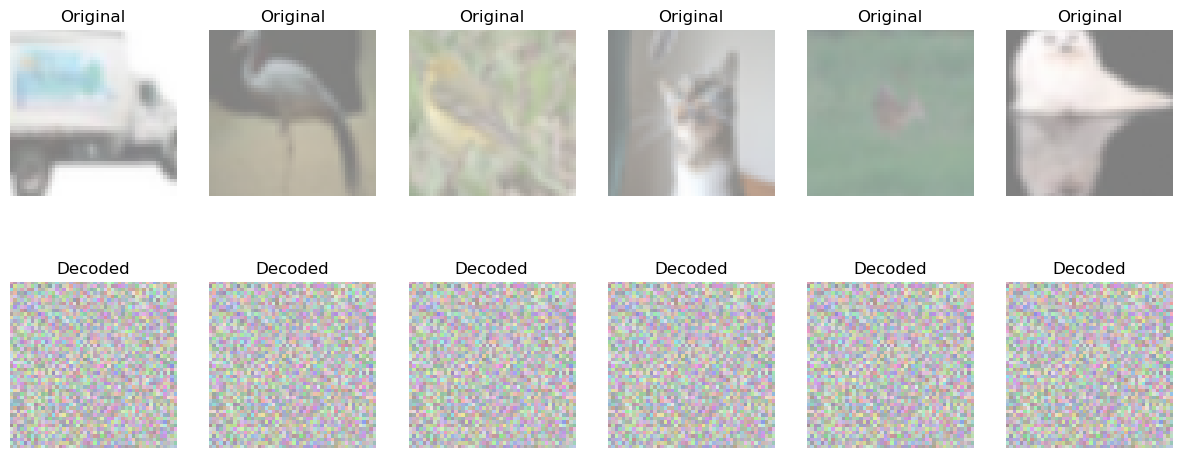

In [116]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, dropout_rate):
        super(MLP, self).__init__()
        layers = []
        for units in hidden_units:
            layers.append(nn.Linear(input_dim, units))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = units
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
       # print(f"MLP input shape: {x.shape}")
        x = self.mlp(x)
        #print(f"MLP output shape: {x.shape}")
        return x

class Encoder(nn.Module):
    def __init__(self, num_heads, num_layers, enc_projection_dim, layer_norm_eps, enc_transformer_units):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.enc_projection_dim = enc_projection_dim

        self.attention_layers = nn.ModuleList()
        self.norm_layers1 = nn.ModuleList()
        self.norm_layers2 = nn.ModuleList()
        self.mlp_layers = nn.ModuleList()

        for _ in range(num_layers):
            self.attention_layers.append(nn.MultiheadAttention(embed_dim=enc_projection_dim, num_heads=num_heads, dropout=0.1))
            self.norm_layers1.append(nn.LayerNorm(enc_projection_dim, eps=layer_norm_eps))
            self.norm_layers2.append(nn.LayerNorm(enc_projection_dim, eps=layer_norm_eps))
            self.mlp_layers.append(MLP(enc_projection_dim, enc_transformer_units, 0.1))

        self.final_norm = nn.LayerNorm(enc_projection_dim, eps=layer_norm_eps)

    def forward(self, x):
        for i in range(self.num_layers):
            #print(f"Encoder layer {i} input shape: {x.shape}")
            x1 = self.norm_layers1[i](x)
            attention_output, _ = self.attention_layers[i](x1, x1, x1)
            x2 = attention_output + x
            x3 = self.norm_layers2[i](x2)
            x3 = self.mlp_layers[i](x3)
            x = x3 + x2
           # print(f"Encoder layer {i} output shape: {x.shape}")
        x = self.final_norm(x)
        #print(f"Encoder final output shape: {x.shape}")
        return x

class Decoder(nn.Module):
    def __init__(self, num_layers, num_heads, enc_projection_dim, dec_projection_dim, layer_norm_eps, dec_transformer_units, image_size):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.dec_projection_dim = dec_projection_dim
        self.image_size = image_size

        self.projection = nn.Linear(enc_projection_dim, dec_projection_dim)
        self.attention_layers = nn.ModuleList()
        self.norm_layers1 = nn.ModuleList()
        self.norm_layers2 = nn.ModuleList()
        self.mlp_layers = nn.ModuleList()

        for _ in range(num_layers):
            self.attention_layers.append(nn.MultiheadAttention(embed_dim=dec_projection_dim, num_heads=num_heads, dropout=0.1))
            self.norm_layers1.append(nn.LayerNorm(dec_projection_dim, eps=layer_norm_eps))
            self.norm_layers2.append(nn.LayerNorm(dec_projection_dim, eps=layer_norm_eps))
            self.mlp_layers.append(MLP(dec_projection_dim, dec_transformer_units, 0.1))

        self.final_norm = nn.LayerNorm(dec_projection_dim, eps=layer_norm_eps)
        self.flatten = nn.Flatten()
        self.pre_final = nn.Linear(dec_projection_dim * NUM_PATCHES, image_size * image_size * 3)
        self.output_layer = nn.Sigmoid()

    def forward(self, x):
        #print(f"Decoder input shape: {x.shape}")
        x = self.projection(x)
        for i in range(self.num_layers):
         #   print(f"Decoder layer {i} input shape: {x.shape}")
            x1 = self.norm_layers1[i](x)
            attention_output, _ = self.attention_layers[i](x1, x1, x1)
            x2 = attention_output + x
            x3 = self.norm_layers2[i](x2)
            x3 = self.mlp_layers[i](x3)
            x = x3 + x2
          #  print(f"Decoder layer {i} output shape: {x.shape}")
        x = self.final_norm(x)
        #print(f"Decoder norm output shape: {x.shape}")
        x = self.flatten(x)
        #print(f"Decoder flattened output shape: {x.shape}")
        x = self.pre_final(x)
        x = self.output_layer(x)
        x = x.view(-1, 3, self.image_size, self.image_size)  # Ensure correct output shape
        #print(f"Decoder final output shape: {x.shape}")
        return x

# Initialize models and optimizer
encoder = Encoder(
    num_heads=ENC_NUM_HEADS,
    num_layers=ENC_LAYERS,
    enc_projection_dim=ENC_PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    enc_transformer_units=ENC_TRANSFORMER_UNITS
)

decoder = Decoder(
    num_layers=DEC_LAYERS,
    num_heads=DEC_NUM_HEADS,
    enc_projection_dim=ENC_PROJECTION_DIM,
    dec_projection_dim=DEC_PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    dec_transformer_units=DEC_TRANSFORMER_UNITS,
    image_size=IMAGE_SIZE
)

# Apply weight initialization
encoder.apply(weights_init)
decoder.apply(weights_init)

# Optimizer
optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4, weight_decay=WEIGHT_DECAY)

# Loss function
criterion = nn.MSELoss()

patch_layer = Patches(patch_size=PATCH_SIZE)
data_iter = iter(train_loader)
images, _ = next(data_iter)
print(f"input images type: {type(images)}")
print("Image shape: ", images.shape)
patches = patch_layer(images)

projected_patches = nn.Linear(PATCH_SIZE * PATCH_SIZE * 3, ENC_PROJECTION_DIM)(patches)
print(f"Projected Patches shape: {projected_patches.shape}")

encoded_patches = encoder(projected_patches)
print(f"Encoded Patches shape: {encoded_patches.shape}")

decoded_image = decoder(encoded_patches)
print(f"Decoded Image shape: {decoded_image.shape}")  # Should be (batch_size, 3, 48, 48)

# Visualization function to display original and decoded images
def visualize_reconstruction(original_images, decoded_images, num_images=6):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        orig_img = TF.to_pil_image(original_images[i].cpu() * 0.5 + 0.5)
        plt.imshow(orig_img)
        plt.title("Original")
        plt.axis("off")

        # Decoded image
        plt.subplot(2, num_images, i + num_images + 1)
        decoded_img = TF.to_pil_image(decoded_images[i].cpu() * 0.5 + 0.5)
        plt.imshow(decoded_img)
        plt.title("Decoded")
        plt.axis("off")
    plt.show()

visualize_reconstruction(images, decoded_image)


In [117]:
class MaskedAutoencoder(nn.Module):
    def __init__(self, train_augmentation_model, test_augmentation_model, patch_layer, patch_encoder, encoder, decoder):
        super(MaskedAutoencoder, self).__init__()
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, criterion, test=False):
        # Augment the input images
        if test:
            augmented_images = torch.stack([self.test_augmentation_model(TF.to_pil_image(img)) for img in images])
        else:
            augmented_images = torch.stack([self.train_augmentation_model(TF.to_pil_image(img)) for img in images])
        
        # Patch the augmented images
        patches = self.patch_layer(augmented_images)
        
        # Encode the patches
        unmasked_embeddings, masked_embeddings, unmasked_positions, mask_indices, unmask_indices = self.patch_encoder(patches)
        
        # Check the mask proportion
        mask_ratio = mask_indices.size(1) / patches.size(1)
        print(f"Mask proportion during training: {mask_ratio:.2f}")
        
        # Pass the unmasked patches to the encoder
        encoder_outputs = self.encoder(unmasked_embeddings)
        
        # Create the decoder inputs
        encoder_outputs += unmasked_positions
        decoder_inputs = torch.cat([encoder_outputs, masked_embeddings], dim=1)
        
        # Decode the inputs
        decoder_outputs = self.decoder(decoder_inputs)
        
        # Re-patch the decoder outputs
        decoder_patches = self.patch_layer(decoder_outputs)
        
        # Gather the patches corresponding to the masked indices
        mask_indices_expanded = mask_indices.unsqueeze(-1).expand(-1, -1, patches.size(-1))
        loss_patch = patches.gather(1, mask_indices_expanded)
        
        mask_indices_expanded_output = mask_indices.unsqueeze(-1).expand(-1, -1, decoder_patches.size(-1))
        loss_output = decoder_patches.gather(1, mask_indices_expanded_output)
        
        # Compute the total loss
        total_loss = criterion(loss_patch, loss_output)
        
        return total_loss, loss_patch, loss_output

    def train_step(self, images, criterion, optimizer):
        self.train()
        optimizer.zero_grad()
        total_loss, loss_patch, loss_output = self.calculate_loss(images, criterion)
        total_loss.backward()
        optimizer.step()
        return total_loss

    def test_step(self, images, criterion):
        self.eval()
        with torch.no_grad():
            total_loss, loss_patch, loss_output = self.calculate_loss(images, criterion, test=True)
        return total_loss

    def train_step(self, images, criterion, optimizer):
        self.train()
        optimizer.zero_grad()
        total_loss, loss_patch, loss_output = self.calculate_loss(images, criterion)
        total_loss.backward()
        optimizer.step()
        return total_loss

    def test_step(self, images, criterion):
        self.eval()
        with torch.no_grad():
            total_loss, loss_patch, loss_output = self.calculate_loss(images, criterion, test=True)
        return total_loss


encoder = Encoder(
    num_heads=ENC_NUM_HEADS,
    num_layers=ENC_LAYERS,
    enc_projection_dim=ENC_PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    enc_transformer_units=ENC_TRANSFORMER_UNITS
)

decoder = Decoder(
    num_layers=DEC_LAYERS,
    num_heads=DEC_NUM_HEADS,
    enc_projection_dim=ENC_PROJECTION_DIM,
    dec_projection_dim=DEC_PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    dec_transformer_units=DEC_TRANSFORMER_UNITS,
    image_size=IMAGE_SIZE
)

train_augmentation_model = transforms.Compose([
    transforms.Resize((INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20)),
    transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()  # Convert PIL Image back to tensor
])

test_augmentation_model = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()  # Convert PIL Image back to tensor
])

encoder.apply(weights_init)
decoder.apply(weights_init)
train_transform = get_train_transforms()
test_transform = get_test_transforms()
patch_encoder = PatchEncoder()
patch_layer = Patches(patch_size=PATCH_SIZE)
mae = MaskedAutoencoder(train_augmentation_model, test_augmentation_model, patch_layer, patch_encoder, encoder, decoder)
mae.apply(weights_init)

MaskedAutoencoder(
  (patch_layer): Patches()
  (patch_encoder): PatchEncoder(
    (projection): Linear(in_features=108, out_features=128, bias=True)
  )
  (encoder): Encoder(
    (attention_layers): ModuleList(
      (0-5): 6 x MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
    )
    (norm_layers1): ModuleList(
      (0-5): 6 x LayerNorm((128,), eps=1e-06, elementwise_affine=True)
    )
    (norm_layers2): ModuleList(
      (0-5): 6 x LayerNorm((128,), eps=1e-06, elementwise_affine=True)
    )
    (mlp_layers): ModuleList(
      (0-5): 6 x MLP(
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=256, out_features=128, bias=True)
          (4): GELU(approximate='none')
          (5): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (final_n

In [118]:
class TrainMonitor:
    def __init__(self, model, test_images, epoch_interval=None):
        self.model = model
        self.test_images = test_images
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = torch.stack([self.model.test_augmentation_model(TF.to_pil_image(img)) for img in self.test_images])
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = torch.cat([test_encoder_outputs, test_masked_embeddings], axis=1)
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a masked patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(test_patches, test_unmask_indices)
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(test_masked_patch)
            reconstructed_image = test_decoder_outputs[idx].permute(1, 2, 0).detach().cpu().numpy()

            # Debug statements to check shapes
            print(f"original_image shape: {original_image.shape}")
            print(f"masked_image shape: {masked_image.shape}")
            print(f"reconstructed_image shape: {reconstructed_image.shape}")

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

            # Convert original image to (H, W, C)
            original_image_np = original_image.permute(1, 2, 0).detach().cpu().numpy()
            ax[0].imshow(original_image_np)
            ax[0].set_title(f"Original: {epoch:03d}")

            # Ensure masked_image is reshaped correctly before displaying
            #masked_image_np = masked_image.permute(1, 2, 0).detach().cpu().numpy()
            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Reconstructed: {epoch:03d}")

            plt.show()
            plt.close()


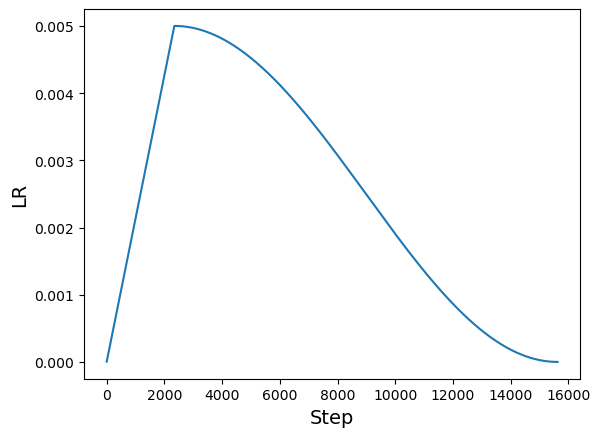

Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0934
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0947
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0964
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0983
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0935
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0933
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0924
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0937
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0951
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0943
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0916
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0928
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0908
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0925
Mask proportion during training: 0.75
Epoch [1/100], Loss: 0.0922
Mask propo

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler

class WarmUpCosine(LRScheduler):
    def __init__(self, optimizer: optim, total_steps: int, warmup_steps: int, learning_rate_base: float, warmup_learning_rate: float, last_epoch: int = -1):
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = np.pi
        super(WarmUpCosine, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1  

        if step > self.total_steps:
            return [0.0 for _ in self.base_lrs]

        cos_annealed_lr = 0.5 * self.learning_rate_base * (1 + np.cos(self.pi * (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)))

        if step < self.warmup_steps:
            slope = (self.learning_rate_base - self.warmup_learning_rate) / self.warmup_steps
            warmup_rate = slope * step + self.warmup_learning_rate
            return [warmup_rate for _ in self.base_lrs]
        else:
            return [cos_annealed_lr for _ in self.base_lrs]

total_steps = int((len(train_loader.dataset) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)

optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = WarmUpCosine(optimizer, total_steps=total_steps, warmup_steps=warmup_steps, learning_rate_base=LEARNING_RATE, warmup_learning_rate=0.0)

# Plot the learning rate schedule
lrs = []
for step in range(total_steps):
    scheduler.step()
    lrs.append(optimizer.param_groups[0]['lr'])

plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

test_images, _ = next(iter(test_loader))

train_monitor = TrainMonitor(mae, test_images, epoch_interval=1)

# Training loop
for epoch in range(EPOCHS):
    mae.train()
    for images, _ in train_loader:
        optimizer.zero_grad()
        loss = mae.train_step(images, criterion, optimizer)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss:.4f}")
        scheduler.step()

    # Validation step
    with torch.no_grad():
        val_loss = 0.0
        for val_images, _ in val_loader:
            loss = mae.test_step(val_images, criterion)
            val_loss += loss
        print(f"Epoch [{epoch+1}/{EPOCHS}], Validation Loss: {val_loss/len(val_loader):.4f}")

    # Call the monitor at the end of each epoch
    train_monitor.on_epoch_end(epoch)

# Testing step
with torch.no_grad():
    test_loss = 0.0
    for test_images, _ in test_loader:
        loss = mae.test_step(test_images, criterion)
        test_loss += loss
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")